In [61]:
import numpy as np
import tensorflow as tf
from tensorflow. keras.preprocessing.image import load_img,img_to_array
import tensorflow.keras.backend as K
from tensorflow. keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow. keras.models import Sequential,Model,save_model,load_model
from tensorflow. keras.layers import Conv2D,Dense,Flatten;
from tensorflow. keras.regularizers import l2
from tensorflow. keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

#Data Augmentation

In [62]:

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150,150),
                                                 batch_size =32,
                                                 class_mode = 'categorical')
test_datagen = ImageDataGenerator(
        rescale=1./255,
        )
testing_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150,150),
                                                 batch_size =32,
                                                 class_mode = 'categorical')

Found 1956 images belonging to 3 classes.
Found 492 images belonging to 3 classes.


In [63]:
training_set.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [64]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [65]:
for layer in model.layers:
    layer.trainable = False 

In [66]:
x=Flatten()(model.output)
x=Dense(units=1024,activation ='relu')(x)
x=Dense(units=512,activation ='relu')(x)
output =Dense(units=3,activation='softmax')(x)
final_model =Model(inputs =model.input,outputs =output)
final_model.compile(loss='categorical_crossentropy',optimizer= Adam(),metrics=['accuracy']) 

In [67]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)


In [68]:
with tf.device("/gpu:0"):
  history=final_model.fit(training_set,validation_data =testing_set,epochs=20,callbacks=[callback])

Epoch 1/20
62/62 [==============================] - 13s 206ms/step - loss: 4.7503 - accuracy: 0.7500 - val_loss: 0.6209 - val_accuracy: 0.8943
Epoch 2/20
62/62 [==============================] - 12s 189ms/step - loss: 0.6305 - accuracy: 0.8471 - val_loss: 0.4006 - val_accuracy: 0.8882
Epoch 3/20
62/62 [==============================] - 12s 188ms/step - loss: 0.4701 - accuracy: 0.8528 - val_loss: 0.4372 - val_accuracy: 0.8862
Epoch 4/20
62/62 [==============================] - 12s 189ms/step - loss: 0.3702 - accuracy: 0.8804 - val_loss: 0.3599 - val_accuracy: 0.8984
Epoch 5/20
62/62 [==============================] - 12s 189ms/step - loss: 0.2542 - accuracy: 0.9080 - val_loss: 0.2425 - val_accuracy: 0.9228
Epoch 6/20
62/62 [==============================] - 12s 185ms/step - loss: 0.3089 - accuracy: 0.8957 - val_loss: 0.2543 - val_accuracy: 0.9085
Epoch 7/20
62/62 [==============================] - 12s 186ms/step - loss: 0.2865 - accuracy: 0.8911 - val_loss: 0.2657 - val_accuracy: 0.9024

In [72]:
#final_model.summary()

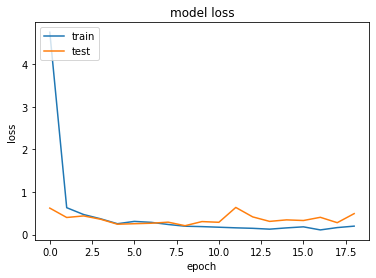

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Fine tuning by making layers trainable

In [77]:
for layer in final_model.layers:
    layer.trainable = True

#Fine Tuning with low learning rate  

In [78]:
final_model.compile(loss='categorical_crossentropy',optimizer= Adam(lr=1e-5),metrics=['accuracy']) 

#Retraining the model

In [79]:

with tf.device("/gpu:0"):
  history2=final_model.fit(training_set,validation_data =testing_set,epochs=10)

Epoch 1/10
62/62 [==============================] - 13s 210ms/step - loss: 0.7227 - accuracy: 0.7030 - val_loss: 0.2595 - val_accuracy: 0.9004
Epoch 2/10
62/62 [==============================] - 12s 194ms/step - loss: 0.5342 - accuracy: 0.7960 - val_loss: 0.2486 - val_accuracy: 0.9024
Epoch 3/10
62/62 [==============================] - 12s 195ms/step - loss: 0.4282 - accuracy: 0.8359 - val_loss: 0.2566 - val_accuracy: 0.8902
Epoch 4/10
62/62 [==============================] - 12s 196ms/step - loss: 0.3539 - accuracy: 0.8768 - val_loss: 0.2391 - val_accuracy: 0.9085
Epoch 5/10
62/62 [==============================] - 12s 195ms/step - loss: 0.3003 - accuracy: 0.8926 - val_loss: 0.2479 - val_accuracy: 0.9106
Epoch 6/10
62/62 [==============================] - 12s 194ms/step - loss: 0.2474 - accuracy: 0.9100 - val_loss: 0.2404 - val_accuracy: 0.9207
Epoch 7/10
62/62 [==============================] - 12s 195ms/step - loss: 0.2152 - accuracy: 0.9172 - val_loss: 0.2280 - val_accuracy: 0.9187

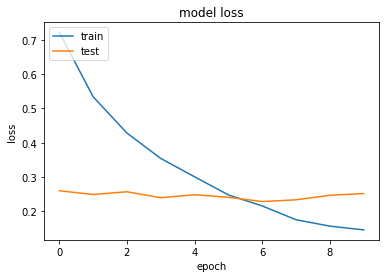

In [80]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#saving model

In [81]:
save_model(final_model,'final_model.h5') 
test_model=load_model('final_model.h5')

#Testing the model

Cow


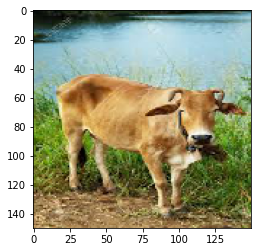

In [83]:
#address ='test/elephant/710.jpeg'
address ='test/cow/19.jpeg'
#address ='test/goat/9.jpeg'
test_image=load_img(address,target_size=(150,150))
plt.imshow(test_image)
test_image=img_to_array(test_image)
test_image= np.expand_dims(test_image,axis=0)

result=test_model.predict(test_image)

result=np.round(result)

if result[0][0]==1:
    prediction='Cow'
elif result[0][1] ==1:
    prediction='Elephant'
elif result[0][2] ==1:
    prediction='Goat'  
else: 
    prediction ='No animal present in the field'
       
print(prediction)